In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [2]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [3]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [4]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
cuda


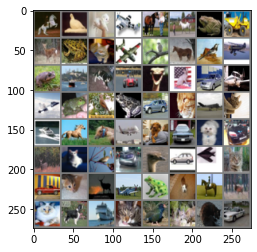

horse bird  dog   plane horse horse frog  truck deer  frog  cat   plane bird  horse bird  plane frog  ship  cat   car   bird  cat   car   plane plane frog  bird  frog  car   cat   plane cat   ship  horse horse plane dog   car   dog   car   deer  cat   bird  car   bird  car   plane cat   car   cat   deer  plane frog  dog   horse deer  cat   dog   ship  cat   bird  deer  cat   car  


In [5]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.01,momentum = 0):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [8]:
begin = time.time()
history, end, lrs = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:15<00:00, 42.82it/s]


Epoch [0], Time taken :17.3053, train_loss : 2.3033, train_acc: 0.1014, val_loss: 2.3029, val_acc: 0.0967


100%|██████████| 657/657 [00:09<00:00, 70.04it/s]


Epoch [1], Time taken :11.0391, train_loss : 2.2993, train_acc: 0.1102, val_loss: 2.2966, val_acc: 0.1284


100%|██████████| 657/657 [00:10<00:00, 61.00it/s]


Epoch [2], Time taken :12.4549, train_loss : 2.2806, train_acc: 0.1545, val_loss: 2.2421, val_acc: 0.1799


100%|██████████| 657/657 [00:09<00:00, 68.60it/s]


Epoch [3], Time taken :11.2795, train_loss : 2.1467, train_acc: 0.2049, val_loss: 2.0749, val_acc: 0.2234


100%|██████████| 657/657 [00:10<00:00, 63.89it/s]


Epoch [4], Time taken :11.9353, train_loss : 2.0383, train_acc: 0.2413, val_loss: 2.0035, val_acc: 0.2519


100%|██████████| 657/657 [00:09<00:00, 66.16it/s]


Epoch [5], Time taken :11.6422, train_loss : 1.9616, train_acc: 0.2698, val_loss: 1.9102, val_acc: 0.2848


100%|██████████| 657/657 [00:09<00:00, 68.70it/s]


Epoch [6], Time taken :11.4165, train_loss : 1.8594, train_acc: 0.3060, val_loss: 1.8170, val_acc: 0.3186


100%|██████████| 657/657 [00:10<00:00, 63.06it/s]


Epoch [7], Time taken :12.4172, train_loss : 1.7650, train_acc: 0.3419, val_loss: 1.7645, val_acc: 0.3436


100%|██████████| 657/657 [00:09<00:00, 70.12it/s]


Epoch [8], Time taken :11.3843, train_loss : 1.6926, train_acc: 0.3742, val_loss: 1.6631, val_acc: 0.3826


100%|██████████| 657/657 [00:09<00:00, 66.95it/s]


Epoch [9], Time taken :11.5874, train_loss : 1.6296, train_acc: 0.4006, val_loss: 1.6161, val_acc: 0.4080


100%|██████████| 657/657 [00:10<00:00, 62.79it/s]


Epoch [10], Time taken :12.2762, train_loss : 1.5874, train_acc: 0.4192, val_loss: 1.5915, val_acc: 0.4173


100%|██████████| 657/657 [00:09<00:00, 67.18it/s]


Epoch [11], Time taken :11.5003, train_loss : 1.5648, train_acc: 0.4298, val_loss: 1.5868, val_acc: 0.4218


100%|██████████| 657/657 [00:10<00:00, 64.65it/s]


Epoch [12], Time taken :12.7245, train_loss : 1.5481, train_acc: 0.4352, val_loss: 1.5604, val_acc: 0.4275


100%|██████████| 657/657 [00:10<00:00, 63.16it/s]


Epoch [13], Time taken :12.1756, train_loss : 1.5266, train_acc: 0.4424, val_loss: 1.5437, val_acc: 0.4293


100%|██████████| 657/657 [00:10<00:00, 61.00it/s]


Epoch [14], Time taken :12.6044, train_loss : 1.5121, train_acc: 0.4498, val_loss: 1.5323, val_acc: 0.4425


100%|██████████| 657/657 [00:10<00:00, 60.59it/s]


Epoch [15], Time taken :12.6427, train_loss : 1.4954, train_acc: 0.4565, val_loss: 1.5132, val_acc: 0.4499


100%|██████████| 657/657 [00:09<00:00, 69.81it/s]


Epoch [16], Time taken :11.3617, train_loss : 1.4813, train_acc: 0.4619, val_loss: 1.4911, val_acc: 0.4559


100%|██████████| 657/657 [00:09<00:00, 67.98it/s]


Epoch [17], Time taken :11.4123, train_loss : 1.4661, train_acc: 0.4709, val_loss: 1.4866, val_acc: 0.4555


100%|██████████| 657/657 [00:11<00:00, 59.44it/s]


Epoch [18], Time taken :12.9298, train_loss : 1.4520, train_acc: 0.4752, val_loss: 1.4793, val_acc: 0.4629


100%|██████████| 657/657 [00:09<00:00, 68.31it/s]


Epoch [19], Time taken :11.4428, train_loss : 1.4365, train_acc: 0.4805, val_loss: 1.4421, val_acc: 0.4750


100%|██████████| 657/657 [00:10<00:00, 63.60it/s]


Epoch [20], Time taken :13.0844, train_loss : 1.4114, train_acc: 0.4907, val_loss: 1.4328, val_acc: 0.4761


100%|██████████| 657/657 [00:09<00:00, 68.65it/s]


Epoch [21], Time taken :11.3133, train_loss : 1.4090, train_acc: 0.4932, val_loss: 1.4239, val_acc: 0.4852


100%|██████████| 657/657 [00:09<00:00, 67.46it/s]


Epoch [22], Time taken :11.4687, train_loss : 1.3980, train_acc: 0.4955, val_loss: 1.4210, val_acc: 0.4819


100%|██████████| 657/657 [00:10<00:00, 61.70it/s]


Epoch [23], Time taken :12.3564, train_loss : 1.3916, train_acc: 0.4999, val_loss: 1.4099, val_acc: 0.4873


100%|██████████| 657/657 [00:09<00:00, 68.66it/s]


Epoch [24], Time taken :11.2789, train_loss : 1.3887, train_acc: 0.5004, val_loss: 1.4025, val_acc: 0.4950


100%|██████████| 657/657 [00:09<00:00, 69.31it/s]


Epoch [25], Time taken :11.2116, train_loss : 1.3750, train_acc: 0.5048, val_loss: 1.4043, val_acc: 0.4925


100%|██████████| 657/657 [00:10<00:00, 62.78it/s]


Epoch [26], Time taken :12.1660, train_loss : 1.3694, train_acc: 0.5070, val_loss: 1.4000, val_acc: 0.4964


100%|██████████| 657/657 [00:09<00:00, 69.84it/s]


Epoch [27], Time taken :11.1368, train_loss : 1.3648, train_acc: 0.5111, val_loss: 1.3957, val_acc: 0.5011


100%|██████████| 657/657 [00:09<00:00, 67.94it/s]


Epoch [28], Time taken :11.3869, train_loss : 1.3617, train_acc: 0.5116, val_loss: 1.3808, val_acc: 0.5014


100%|██████████| 657/657 [00:10<00:00, 64.44it/s]


Epoch [29], Time taken :11.8984, train_loss : 1.3499, train_acc: 0.5158, val_loss: 1.3795, val_acc: 0.5082
Finished Training in 361.2281880378723secs


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

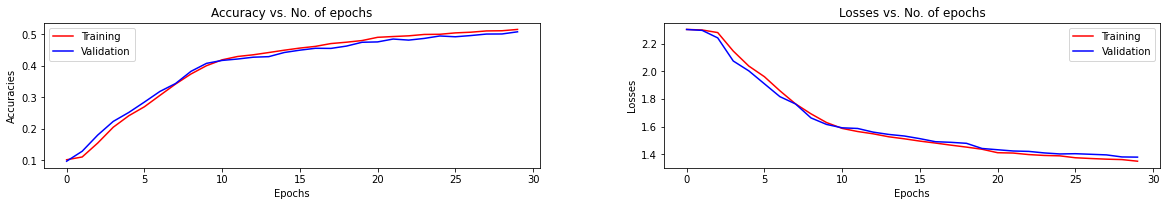

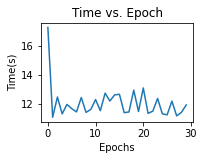

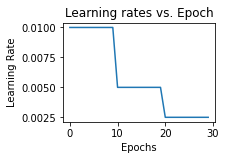

In [10]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.7 %
Accuracy for class: car   is 65.6 %
Accuracy for class: bird  is 33.9 %
Accuracy for class: cat   is 30.8 %
Accuracy for class: deer  is 33.9 %
Accuracy for class: dog   is 43.0 %
Accuracy for class: frog  is 69.1 %
Accuracy for class: horse is 58.5 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 59.7 %
